# Fraud Detection on Transaction Data

## Data stuff

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.chdir(os.getcwd())
os.chdir("C:/Users/MelodyPogula/Downloads")

In [3]:
### Data
train_df = pd.read_csv("transaction.csv")
data = train_df.copy()

X = data.drop(columns=["isFraud"])
y = data["isFraud"]

## split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7406
)


In [4]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns
# one-hot encode
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

## Light GBM

In [ ]:
### Light GBM
lgb_train = lgb.Dataset(X_train_enc, y_train)
lgb_eval = lgb.Dataset(X_test_enc, y_test, reference=lgb_train)
params = {
 "objective": "binary",
 "metric": "auc",
 "boosting_type": "gbdt",
 "learning_rate": 0.05,
 "num_leaves": 64,
 "verbose": -1
}

gbm = lgb.train(
 params,
 lgb_train,
 valid_sets=[lgb_eval],
 num_boost_round=200,
 callbacks=[lgb.early_stopping(stopping_rounds=10)]
)
pred_lgb = gbm.predict(X_test_enc)
auc_lgb = roc_auc_score(y_test, pred_lgb)
print(f"LightGBM AUC: {auc_lgb:.4f}")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.943696
LightGBM AUC: 0.9437


## Cross-Validation

In [ ]:
### Cross-Validation
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7406)
models = {
 "LightGBM": lgb.LGBMClassifier(
 n_estimators=200,
 learning_rate=0.05,
 num_leaves=64,
 subsample=0.8,
 colsample_bytree=0.8,
 random_state=7406
 )
}

In [9]:
cv_results = {}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7406)
for name, model in models.items():
 print(f"\n{name} Cross-Validation (3-fold, sampled):")
 X_sample = X_train_enc.sample(frac=0.25, random_state=42)
 y_sample = y_train.loc[X_sample.index]
 aucs = cross_val_score(model, X_sample, y_sample, cv=cv, scoring="roc_auc", n_jobs=-1)
 cv_results[name] = aucs
 print(f"AUCs: {np.round(aucs, 4)}")
 print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


Random Forest Cross-Validation (3-fold, sampled):
AUCs: [0.8982 0.8957 0.8951]
Mean AUC: 0.8963 ± 0.0014

LightGBM Cross-Validation (3-fold, sampled):
AUCs: [0.9244 0.9197 0.9222]
Mean AUC: 0.9221 ± 0.0019


### Summary Graphs

C:\Users\MelodyPogula\AppData\Local\Temp\ipykernel_22520\673791178.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_df, x="Model", y="AUC", palette="pastel")


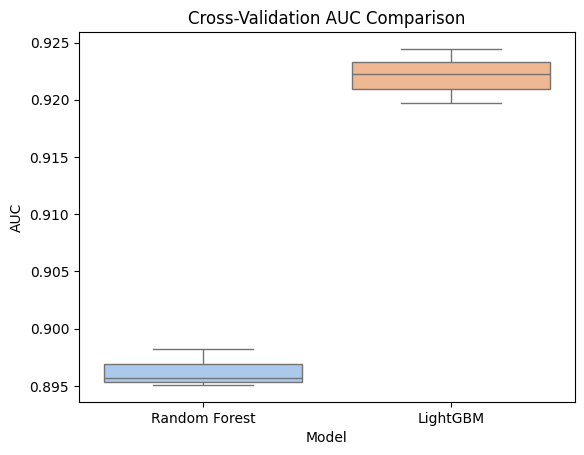

C:\Users\MelodyPogula\AppData\Local\Temp\ipykernel_22520\673791178.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mean_aucs.keys()), y=list(mean_aucs.values()), palette="coolwarm")


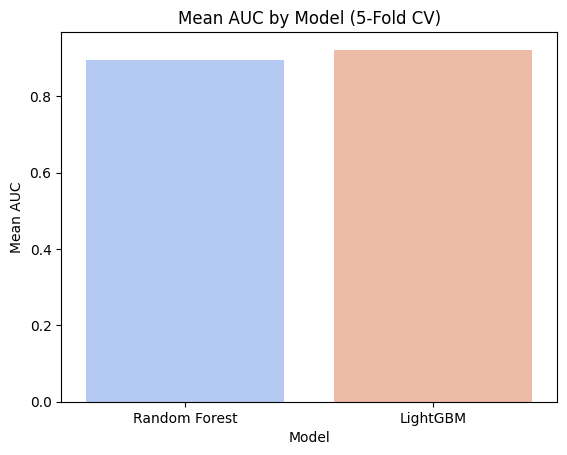

In [ ]:
### Summary graphs
cv_df = (
 pd.DataFrame(cv_results)
 .melt(var_name="Model", value_name="AUC")
)
15
sns.boxplot(data=cv_df, x="Model", y="AUC", palette="pastel")
plt.title("Cross-Validation AUC Comparison")
plt.xlabel("Model")
plt.ylabel("AUC")
plt.show()
